In [2]:
#import libraries

In [2]:
import os
from google.cloud import bigquery
%load_ext google.cloud.bigquery
import pandas_gbq
import pandas_profiling

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import _tree
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import catboost
from catboost import CatBoostClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import plot_roc_curve, f1_score, roc_curve, roc_auc_score,auc, accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix;

/home/liavonava/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.

Using TensorFlow backend.


In [4]:
## 1 STEP - WORKING WITH DATABASE

In [5]:
# get env to work with bigquery

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'dev-rep-final-projects-326152cab3fb.json'
client = bigquery.Client()

In [7]:
# look through all tables

In [8]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.health_metrics`
LIMIT 3

patient  hypertension  heart_disease  avg_glucose_level   bmi
0       81             0              0             202.21  None
1       95             0              1             106.23  None
2      186             0              0              79.92  None

In [9]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.residence_data`
LIMIT 3

id  residence
0   0          0
1   3          0
2   4          0

In [10]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.residence_labels`
LIMIT 3

id Residence_type
0   0          Rural
1   1          Urban

In [11]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.smoking_data`
LIMIT 3

id  smoking
0   3        0
1   6        0
2  11        0

In [12]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.smoking_labels`
LIMIT 3

id   smoking_status
0   0  formerly smoked
1   1          missing
2   2     never smoked

In [13]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.stroke_info`
LIMIT 3

id  stroke
0   0       0
1   1       0
2   2       0

In [14]:
%%bigquery
SELECT * 
FROM `dev-rep-final-projects.stroke_data.personal_data`
LIMIT 3

id gender  age  ever_married
0  511   Male  2.0         False
1  544   Male  2.0         False
2  592   Male  2.0         False

In [15]:
# join all the tables together

In [16]:
%%bigquery 

SELECT  health_metrics.patient, health_metrics.hypertension, health_metrics.heart_disease,
        health_metrics.avg_glucose_level,health_metrics.bmi,
        personal_data.gender, personal_data.age, personal_data.ever_married,
        residence_data.residence,
        smoking_data.smoking,
        stroke_info.stroke,
        work_data.work_type
    
FROM `dev-rep-final-projects.stroke_data.health_metrics` AS health_metrics

JOIN 
`dev-rep-final-projects.stroke_data.personal_data` AS personal_data
ON health_metrics.patient=personal_data.id

JOIN 
`dev-rep-final-projects.stroke_data.residence_data` AS residence_data 
ON health_metrics.patient=residence_data.id

JOIN 
`dev-rep-final-projects.stroke_data.smoking_data` AS smoking_data
ON health_metrics.patient=smoking_data.id

JOIN `dev-rep-final-projects.stroke_data.stroke_info` AS stroke_info
ON health_metrics.patient=stroke_info.id

JOIN `dev-rep-final-projects.stroke_data.work_data` AS work_data
ON health_metrics.patient=work_data.patient_id

LIMIT 5;

patient  hypertension  heart_disease  avg_glucose_level   bmi gender  age  \
0      511             0              0              73.62  20.8   Male  2.0   
1      544             0              0              93.88  17.4   Male  2.0   
2      592             0              0             109.10  20.0   Male  2.0   
3      618             0              0              56.77  20.9   Male  2.0   
4      901             0              0             103.25  19.4   Male  2.0   

   ever_married  residence  smoking  stroke work_type  
0         False          0        1       0  children  
1         False          1        1       0  children  
2         False          0        1       0  children  
3         False          0        1       0  children  
4         False          0        1       0  children

In [17]:
# get the df and download it to csv

In [29]:
sql = '''
SELECT  health_metrics.patient, personal_data.gender, personal_data.age,
        health_metrics.bmi, health_metrics.avg_glucose_level,
        health_metrics.hypertension, health_metrics.heart_disease,
        personal_data.ever_married, work_data.work_type,
        residence_data.residence, smoking_data.smoking,
        stroke_info.stroke
        
    
FROM `dev-rep-final-projects.stroke_data.health_metrics` AS health_metrics

JOIN 
`dev-rep-final-projects.stroke_data.personal_data` AS personal_data
ON health_metrics.patient=personal_data.id

JOIN 
`dev-rep-final-projects.stroke_data.residence_data` AS residence_data 
ON health_metrics.patient=residence_data.id

JOIN 
`dev-rep-final-projects.stroke_data.smoking_data` AS smoking_data
ON health_metrics.patient=smoking_data.id

JOIN `dev-rep-final-projects.stroke_data.stroke_info` AS stroke_info
ON health_metrics.patient=stroke_info.id

JOIN `dev-rep-final-projects.stroke_data.work_data` AS work_data
ON health_metrics.patient=work_data.patient_id;
'''
original = client.query(sql).to_dataframe()
original.to_csv(r'bigquery_df.csv', index = None, header=True)
original.head()

patient gender  age   bmi  avg_glucose_level  hypertension  heart_disease  \
0      511   Male  2.0  20.8              73.62             0              0   
1      544   Male  2.0  17.4              93.88             0              0   
2      592   Male  2.0  20.0             109.10             0              0   
3      618   Male  2.0  20.9              56.77             0              0   
4      901   Male  2.0  19.4             103.25             0              0   

   ever_married work_type  residence  smoking  stroke  
0         False  children          0        1       0  
1         False  children          1        1       0  
2         False  children          0        1       0  
3         False  children          0        1       0  
4         False  children          0        1       0

In [20]:
## 2 STEP -  ANALAZING OF DATA, DATA PREPROCESSING

In [21]:
# gender 1 - Female, 0 - Male (a change was made)

# age

# hypertension: 1 - Yes, 0 - No

# heart_disease: 1 - Yes, 0 - No

# ever_married: 1 - True, 0 - False (a change was made)

# work_type: type of patient occupation 5 unique values

# Residence_type: 1 - Urban, 0 - Rural

# avg_glucose_level: average glucose level

# bmi: Body Mass Index

# smoking_status: 0 - formerly smoked, 1 - missing, 2 - never smoked, 3 - smokes

# stroke: 1 - Yes, 0 - No


In [3]:
df = pd.read_csv('bigquery_df.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
patient              43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
bmi                  41938 non-null float64
avg_glucose_level    43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null bool
work_type            43400 non-null object
residence            43400 non-null int64
smoking              43400 non-null int64
stroke               43400 non-null int64
dtypes: bool(1), float64(3), int64(6), object(2)
memory usage: 3.7+ MB


In [4]:
df['gender'] = df['gender'].map({'Male':0, 'Female':1})
df['ever_married'] = df['ever_married'].apply(lambda x: 0 if x == False else 1)
df.head()

patient  gender  age   bmi  avg_glucose_level  hypertension  heart_disease  \
0      511     0.0  2.0  20.8              73.62             0              0   
1      544     0.0  2.0  17.4              93.88             0              0   
2      592     0.0  2.0  20.0             109.10             0              0   
3      618     0.0  2.0  20.9              56.77             0              0   
4      901     0.0  2.0  19.4             103.25             0              0   

   ever_married work_type  residence  smoking  stroke  
0             0  children          0        1       0  
1             0  children          1        1       0  
2             0  children          0        1       0  
3             0  children          0        1       0  
4             0  children          0        1       0

In [47]:
df.describe()

patient        gender           age           bmi  \
count  43400.000000  43389.000000  43400.000000  41938.000000   
mean   21699.500000      0.591509     42.217894     28.605038   
std    12528.645178      0.491560     22.519649      7.770020   
min        0.000000      0.000000      0.080000     10.100000   
25%    10849.750000      0.000000     24.000000     23.200000   
50%    21699.500000      1.000000     44.000000     27.700000   
75%    32549.250000      1.000000     60.000000     32.900000   
max    43399.000000      1.000000     82.000000     97.600000   

       avg_glucose_level  hypertension  heart_disease  ever_married  \
count       43400.000000  43400.000000   43400.000000  43400.000000   
mean          104.482750      0.093571       0.047512      0.643733   
std            43.111751      0.291235       0.212733      0.478901   
min            55.000000      0.000000       0.000000      0.000000   
25%            77.540000      0.000000       0.000000      0.000000   
50%            91.580000      0.000000       0.000000      1.000000   
75%           112.070000      0.000000       0.000000      1.000000   
max           291.050000      1.000000       1.000000      1.000000   

          residence       smoking        stroke  
count  43400.000000  43400.000000  43400.000000  
mean       0.501290      1.499631      0.018041  
std        0.500004      0.947479      0.133103  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        1.000000      2.000000      0.000000  
75%        1.000000      2.000000      0.000000  
max        1.000000      3.000000      1.000000

In [26]:
#df.profile_report()

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/liavonava/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in greater

/home/liavonava/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning:

invalid value encountered in less

/home/liavonava/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/home/liavonava/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



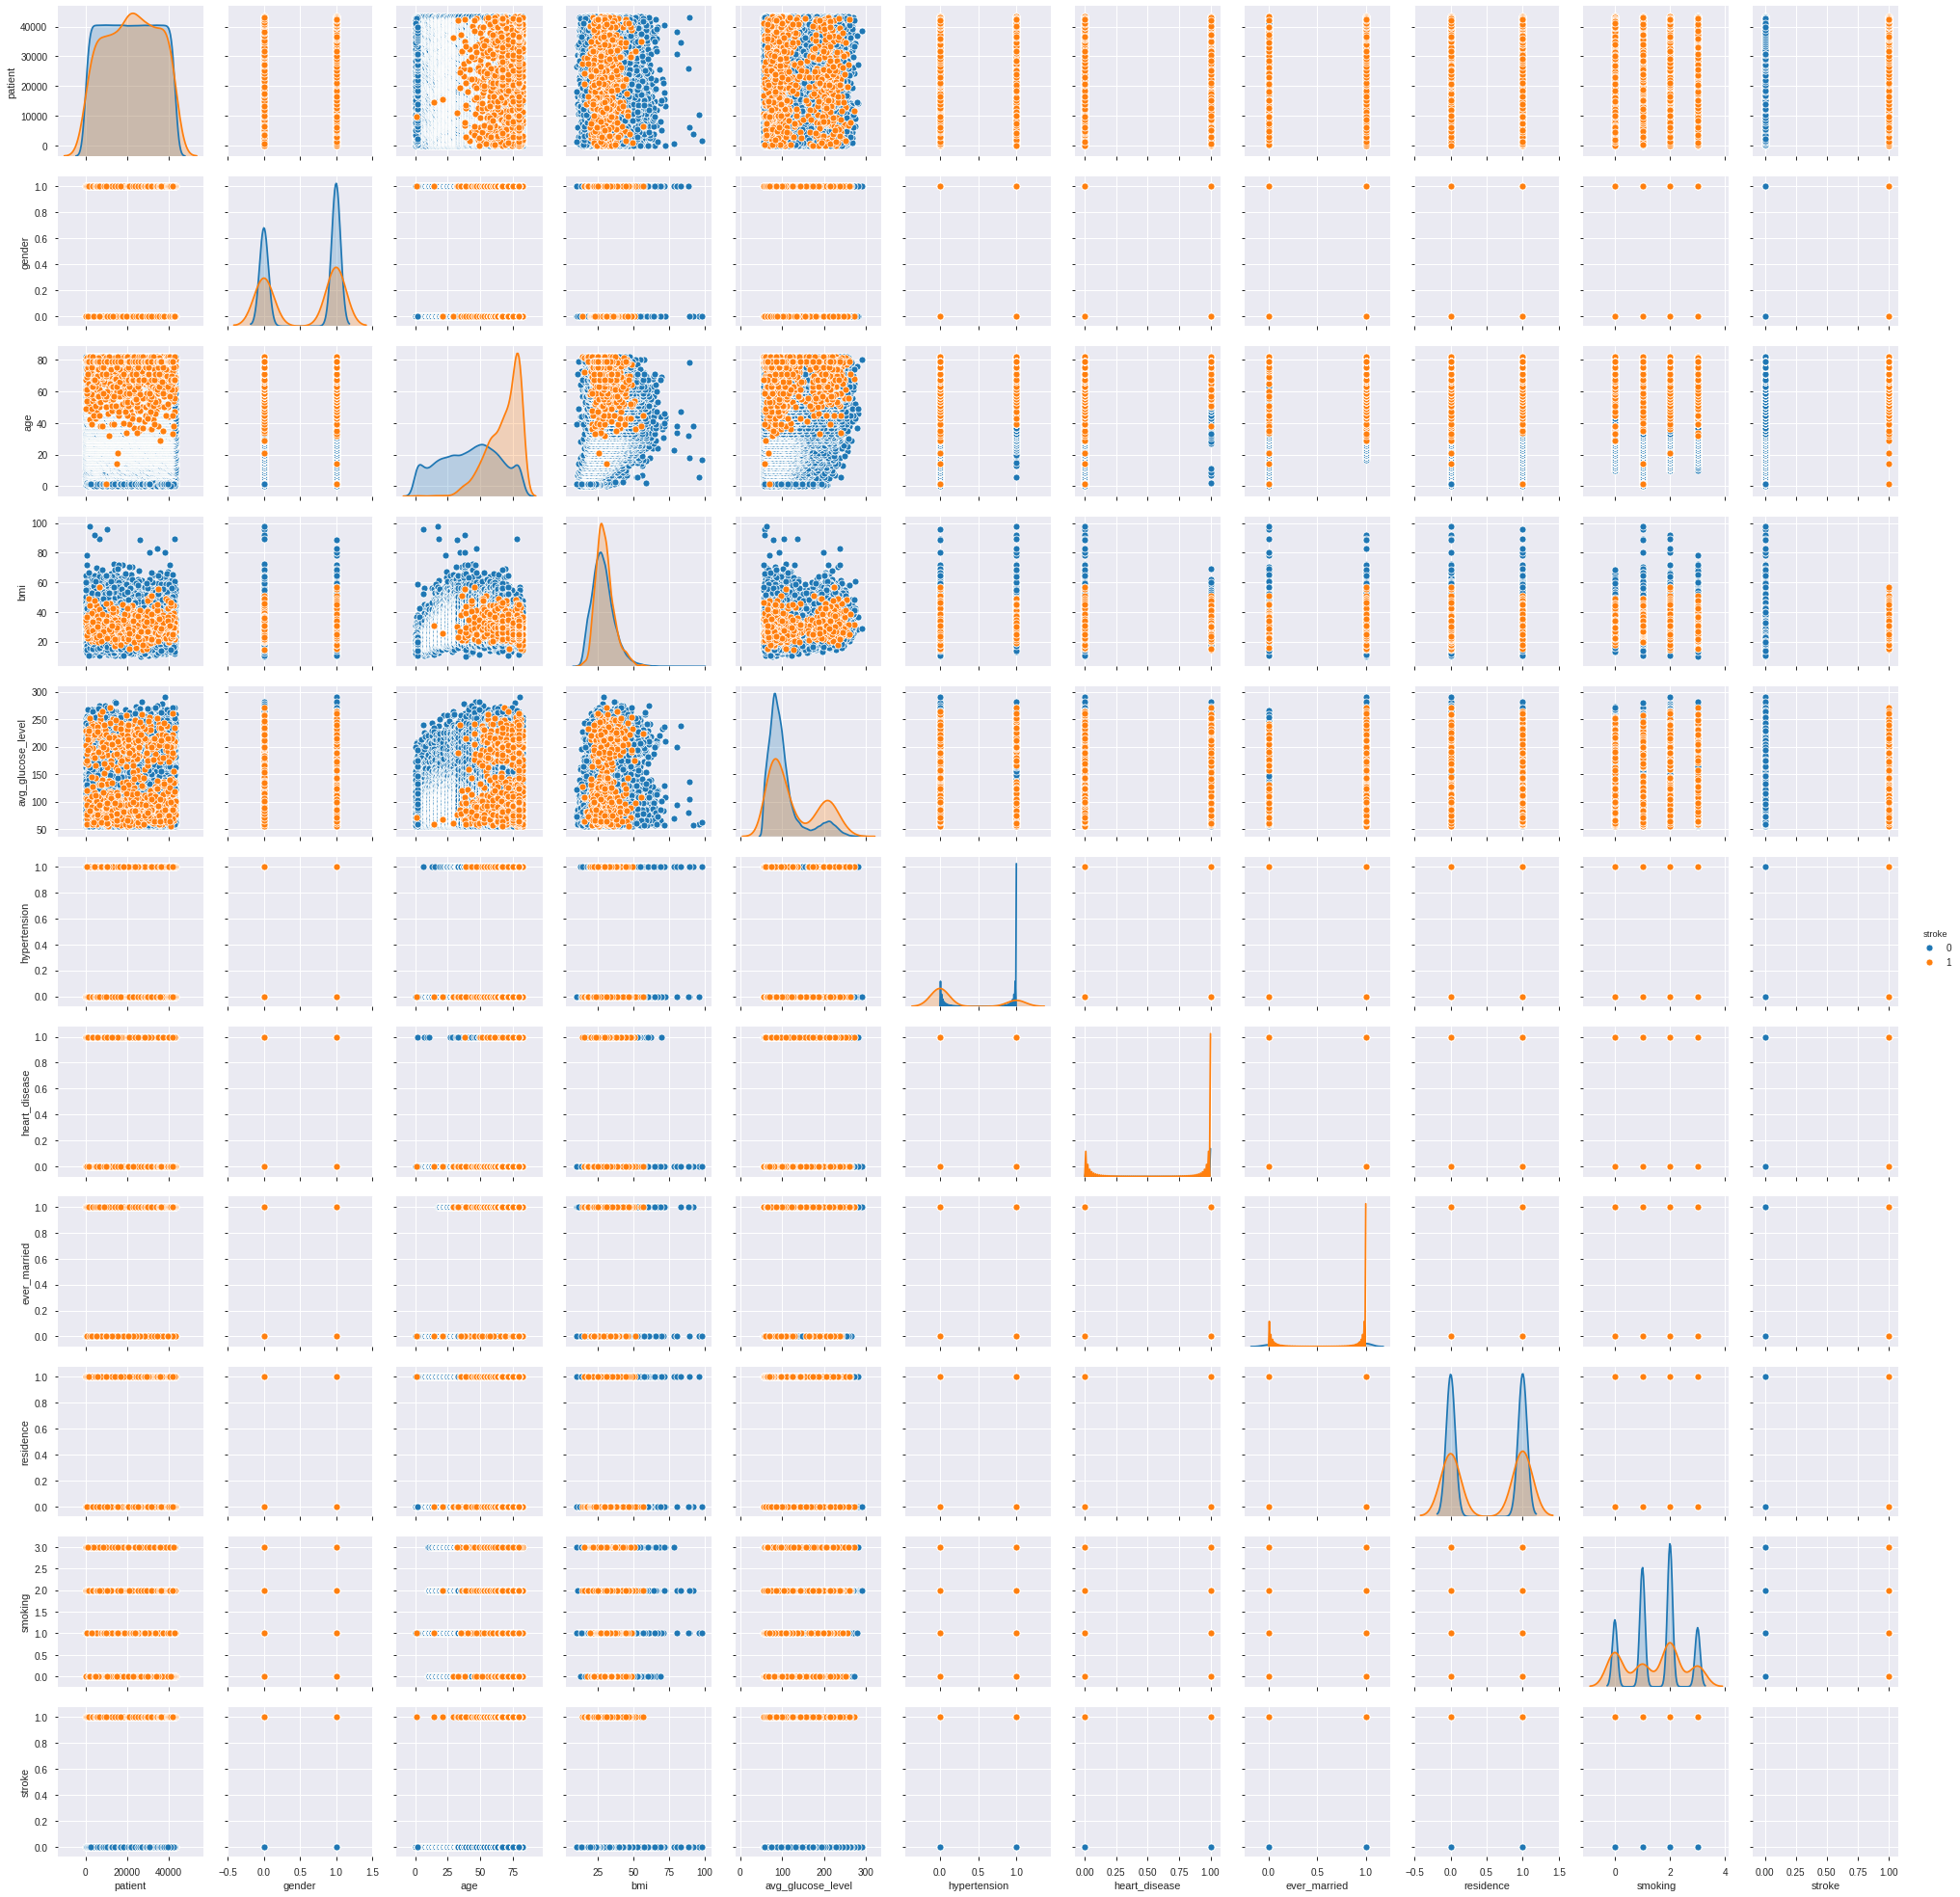

In [36]:
sns.pairplot(hue='stroke', data=df)
plt.show();

In [368]:

# observed problems:
# 1 do we need need patient id?
# 2 missing values in gender
# 3 change work type 
# 4 unknown values in smoking
# 5 missing values in bmi 


In [6]:
# 1 do we need need patient id?
# lets check weather there are dublicates
len(df.patient.unique())-df.shape[0]

0

In [7]:
#as there is no dublicates we can drop column 'patient id'
df.drop(['patient'], axis=1, inplace=True)
df.head()

gender  age   bmi  avg_glucose_level  hypertension  heart_disease  \
0     0.0  2.0  20.8              73.62             0              0   
1     0.0  2.0  17.4              93.88             0              0   
2     0.0  2.0  20.0             109.10             0              0   
3     0.0  2.0  20.9              56.77             0              0   
4     0.0  2.0  19.4             103.25             0              0   

   ever_married work_type  residence  smoking  stroke  
0             0  children          0        1       0  
1             0  children          1        1       0  
2             0  children          0        1       0  
3             0  children          0        1       0  
4             0  children          0        1       0

In [8]:
df.gender.unique()

array([ 0., nan,  1.])

In [10]:
# 2 deal with missing values in gender
# all observations with unknown values has 0 target
df = df.dropna(subset=['gender'])
df.shape

(43389, 11)

In [11]:
df.head()

gender  age   bmi  avg_glucose_level  hypertension  heart_disease  \
0     0.0  2.0  20.8              73.62             0              0   
1     0.0  2.0  17.4              93.88             0              0   
2     0.0  2.0  20.0             109.10             0              0   
3     0.0  2.0  20.9              56.77             0              0   
4     0.0  2.0  19.4             103.25             0              0   

   ever_married work_type  residence  smoking  stroke  
0             0  children          0        1       0  
1             0  children          1        1       0  
2             0  children          0        1       0  
3             0  children          0        1       0  
4             0  children          0        1       0

In [12]:
# 3 onehotencoding
df = pd.get_dummies(data=df, columns=['work_type'])
df.head()

gender  age   bmi  avg_glucose_level  hypertension  heart_disease  \
0     0.0  2.0  20.8              73.62             0              0   
1     0.0  2.0  17.4              93.88             0              0   
2     0.0  2.0  20.0             109.10             0              0   
3     0.0  2.0  20.9              56.77             0              0   
4     0.0  2.0  19.4             103.25             0              0   

   ever_married  residence  smoking  stroke  work_type_Govt_job  \
0             0          0        1       0                   0   
1             0          1        1       0                   0   
2             0          0        1       0                   0   
3             0          0        1       0                   0   
4             0          0        1       0                   0   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                       0                  0                        0   
1                       0                  0                        0   
2                       0                  0                        0   
3                       0                  0                        0   
4                       0                  0                        0   

   work_type_children  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1

In [13]:
# 4.1 unknown smoking for chidren put never smoked

In [14]:
df[df['smoking']==1].count()[0]

13290

In [15]:
df[(df['smoking']==1)&(df['age']<=18)].count()[0]

6311

In [16]:
# for unknown smoking values and age < 18 put category 2 (never smoked)
df['smoking'][(df['smoking']==1)&(df['age']<=18)] = [2] * df[(df['smoking']==1)&(df['age']<=18)].count()[0]

/home/liavonava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df[df['smoking']==1].count()[0]
#deal after will have bmi

6979

In [20]:
# 5 missing values in bmi and smoking 
# drop where target is 0

index_names = df[(df['stroke'] == 0)&(df['bmi'].isnull())].index
df.drop(index_names, inplace=True)

In [21]:
index_names2 = df[(df['stroke'] == 0)&(df['smoking']==1)].index
df.drop(index_names2, inplace=True)

In [22]:
df.shape

(35523, 15)

In [216]:
# use k-NN method

X_train = df[~df['bmi'].isnull()].drop('bmi', axis=1)
X_test = df[df['bmi'].isnull()].drop('bmi', axis=1)
y_train = df['bmi'][~df['bmi'].isnull()]
#y_test = df['bmi'][df['bmi'].isnull()]

In [220]:
lab_enc = LabelEncoder()
y_train_enc = lab_enc.fit_transform(y_train)

In [222]:
hyperparameters = {'n_neighbors': list(range(3,15)),
                   'weights': ['distance', 'uniform'], 
                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    
gscv = GridSearchCV(KNeighborsClassifier(),
                    param_grid=hyperparameters,
                    scoring='f1_weighted',
                    cv=3,
                    n_jobs=-1)

gscv_results = gscv.fit(X_train, y_train_enc)
gscv_results.best_params_

/home/liavonava/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

In [224]:
knn_model = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', weights='distance')
knn_model.fit(X_train, y_train_enc)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [225]:
y_test = knn_model.predict(X_test)

In [226]:
df['bmi'][df['bmi'].isnull()] = y_test

/home/liavonava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [227]:
df['bmi'].isnull().sum()

0

In [228]:
# 4.2 missing values in smoking 

X_train = df[df['smoking']!=1].drop('smoking', axis=1)
X_test = df[df['smoking']==1].drop('smoking', axis=1)
y_train = df['smoking'][df['smoking']!=1]
#y_test = df['smoking'][df['smoking']==1]

In [229]:
hyperparameters = {'n_neighbors': list(range(3,15)),
                   'weights': ['distance', 'uniform'], 
                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    
gscv = GridSearchCV(KNeighborsClassifier(),
                    param_grid=hyperparameters,
                    scoring='f1_weighted',
                    cv=3, 
                    n_jobs=-1)

gscv_results = gscv.fit(X_train, y_train)
gscv_results.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 4, 'weights': 'distance'}

In [230]:
knn_model = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', weights='distance')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [231]:
y_test = knn_model.predict(X_test)

In [232]:
df['smoking'][df['smoking']==1] = y_test

/home/liavonava/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
data = df.copy()
data.head()

NameError: name 'df' is not defined

In [70]:
# add column for categories of bmi, and scale data

In [234]:
def bmi_cat(col):
    
    bmi = col[0]
    
    if bmi < 18.5:
        return 0
    elif (bmi > 18.5 and bmi < 24.9):
        return 1
    elif (bmi > 24.9 and bmi < 29.9):
        return 2
    else:
        return 3
    
data['bmi_cat'] = data[['bmi']].apply(bmi_cat, axis=1)

In [235]:
robust_scaler = RobustScaler()

data['age_scaled'] = robust_scaler.fit_transform(data[['age']])
data.drop(['age'],axis=1, inplace=True)

data['bmi_scaled'] = robust_scaler.fit_transform(data[['bmi']])
data.drop(['bmi'],axis=1, inplace=True)

data['avg_glucose_scaled'] = robust_scaler.fit_transform(data[['avg_glucose_level']])
data.drop(['avg_glucose_level'],axis=1, inplace=True)

In [236]:
data.head()

gender  hypertension  heart_disease  ever_married  residence  smoking  \
0     0.0             0              0             0          0        2   
1     0.0             0              0             0          1        2   
2     0.0             0              0             0          0        2   
3     0.0             0              0             0          0        2   
4     0.0             0              0             0          0        2   

   stroke  work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0       0                   0                       0                  0   
1       0                   0                       0                  0   
2       0                   0                       0                  0   
3       0                   0                       0                  0   
4       0                   0                       0                  0   

   work_type_Self-employed  work_type_children  bmi_cat  age_scaled  \
0                        0                   1        1   -1.052632   
1                        0                   1        0   -1.052632   
2                        0                   1        1   -1.052632   
3                        0                   1        1   -1.052632   
4                        0                   1        1   -1.052632   

   bmi_scaled  avg_glucose_scaled  
0   -0.686869           -0.516260  
1   -1.030303            0.072009  
2   -0.767677            0.513937  
3   -0.676768           -1.005517  
4   -0.828283            0.344077

In [74]:
# scaling for age, bmi, glucose

In [237]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [1]:
data.to_csv('final_df.csv')

NameError: name 'data' is not defined

In [4]:
final_df = pd.read_csv('final_df.csv')
final_df.drop('Unnamed: 0', axis=1, inplace=True)
final_df.head()

gender  hypertension  heart_disease  ever_married  residence  smoking  \
0     0.0             0              0             0          0        2   
1     0.0             0              0             0          1        2   
2     0.0             0              0             0          0        2   
3     0.0             0              0             0          0        2   
4     0.0             0              0             0          0        2   

   stroke  work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0       0                   0                       0                  0   
1       0                   0                       0                  0   
2       0                   0                       0                  0   
3       0                   0                       0                  0   
4       0                   0                       0                  0   

   work_type_Self-employed  work_type_children  bmi_cat  age_scaled  \
0                        0                   1        1   -1.052632   
1                        0                   1        0   -1.052632   
2                        0                   1        1   -1.052632   
3                        0                   1        1   -1.052632   
4                        0                   1        1   -1.052632   

   bmi_scaled  avg_glucose_scaled  
0   -0.686869           -0.516260  
1   -1.030303            0.072009  
2   -0.767677            0.513937  
3   -0.676768           -1.005517  
4   -0.828283            0.344077

In [5]:
final_df.drop('bmi_cat', axis=1, inplace=True)

In [6]:
final_df.shape

(35523, 15)

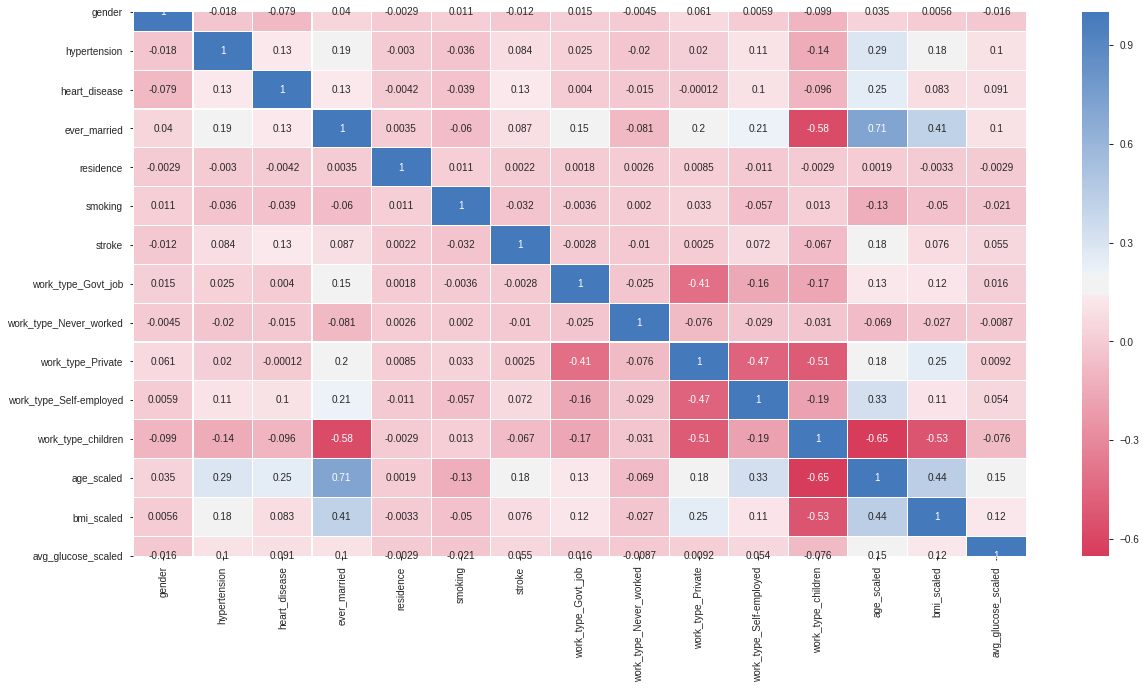

In [89]:
#corr = final_df.corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)
#corr.style.background_gradient(cmap=cmap)

plt.figure(figsize=(20,10))
sns.heatmap(final_df.astype(float).corr(method='spearman'), linewidths=0.1, vmax=1, square=False, linecolor='white', annot=True, cmap=cmap)



In [56]:
final_df[final_df['stroke']==0].shape

(34740, 16)

In [41]:
final_df[(final_df['stroke']==1)&(final_df['gender']==0)].describe()

gender  hypertension  heart_disease  ever_married   residence  \
count   352.0    352.000000     352.000000    352.000000  352.000000   
mean      0.0      0.238636       0.284091      0.906250    0.508523   
std       0.0      0.426857       0.451622      0.291896    0.500639   
min       0.0      0.000000       0.000000      0.000000    0.000000   
25%       0.0      0.000000       0.000000      1.000000    0.000000   
50%       0.0      0.000000       0.000000      1.000000    1.000000   
75%       0.0      0.000000       1.000000      1.000000    1.000000   
max       0.0      1.000000       1.000000      1.000000    1.000000   

          smoking  stroke  work_type_Govt_job  work_type_Never_worked  \
count  352.000000   352.0          352.000000                   352.0   
mean     1.357955     1.0            0.088068                     0.0   
std      1.248244     0.0            0.283797                     0.0   
min      0.000000     1.0            0.000000                     0.0   
25%      0.000000     1.0            0.000000                     0.0   
50%      2.000000     1.0            0.000000                     0.0   
75%      2.000000     1.0            0.000000                     0.0   
max      3.000000     1.0            1.000000                     0.0   

       work_type_Private  work_type_Self-employed  work_type_children  \
count         352.000000               352.000000               352.0   
mean            0.590909                 0.321023                 0.0   
std             0.492366                 0.467534                 0.0   
min             0.000000                 0.000000                 0.0   
25%             0.000000                 0.000000                 0.0   
50%             1.000000                 0.000000                 0.0   
75%             1.000000                 1.000000                 0.0   
max             1.000000                 1.000000                 0.0   

          bmi_cat  age_scaled  bmi_scaled  avg_glucose_scaled  
count  352.000000  352.000000  352.000000          352.000000  
mean     2.465909    0.678230    3.522211            1.160863  
std      0.695101    0.306814    7.331278            1.741709  
min      0.000000   -0.552632   -1.343434           -1.036585  
25%      2.000000    0.473684   -0.050505           -0.265970  
50%      3.000000    0.736842    0.363636            0.393583  
75%      3.000000    0.947368    1.010101            2.887268  
max      3.000000    1.052632   32.969697            5.236353

In [ ]:
#################

In [ ]:
## 3 STEP -  MODELLING

In [57]:
# 15 make a train/test datasets from model_df

X = final_df.drop(['stroke'], axis=1)
y = final_df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42, stratify=y)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28418, 14), (7105, 14), (28418,), (7105,))

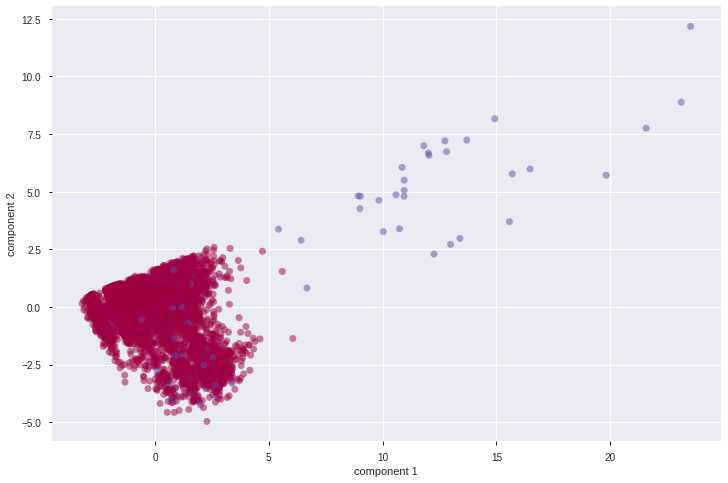

In [81]:

from sklearn.decomposition import PCA


pca = PCA(2) 
projected = pca.fit_transform(X_train)

mask = np.zeros(projected.shape[0], dtype=int)
mask[:10000] = 1
np.random.shuffle(mask)
mask = mask.astype(bool)

plt.figure(figsize=(12,8))

plt.scatter(projected[mask, 0], projected[mask, 1],
            c=y_train.astype(int)[mask], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')

plt.show()


In [27]:
X_train

gender  hypertension  heart_disease  ever_married  residence  smoking  \
28977     1.0             1              0             0          1        2   
24097     1.0             0              0             1          1        2   
10476     0.0             0              0             1          1        3   
1525      0.0             0              0             0          0        2   
1900      0.0             0              0             0          1        2   
...       ...           ...            ...           ...        ...      ...   
27634     1.0             0              0             1          0        2   
18764     1.0             0              0             0          1        3   
30778     1.0             0              1             1          0        3   
7292      0.0             0              0             1          0        2   
19305     1.0             0              0             0          0        3   

       work_type_Govt_job  work_type_Never_worked  work_type_Private  \
28977                   0                       0                  0   
24097                   0                       0                  1   
10476                   0                       0                  0   
1525                    0                       0                  0   
1900                    0                       0                  0   
...                   ...                     ...                ...   
27634                   0                       0                  1   
18764                   0                       0                  1   
30778                   0                       0                  0   
7292                    0                       0                  1   
19305                   0                       0                  1   

       work_type_Self-employed  work_type_children  bmi_cat  age_scaled  \
28977                        1                   0        2   -0.131579   
24097                        0                   0        2    0.157895   
10476                        1                   0        1    0.026316   
1525                         0                   1        0   -0.868421   
1900                         0                   1        0   -0.815789   
...                        ...                 ...      ...         ...   
27634                        0                   0        3    0.710526   
18764                        0                   0        3   -0.526316   
30778                        1                   0        3    0.184211   
7292                         0                   0        3    0.315789   
19305                        0                   0        3   -0.473684   

       bmi_scaled  avg_glucose_scaled  
28977   -0.171717            0.023519  
24097   -0.212121           -1.049942  
10476   -0.636364            0.009292  
1525    -1.080808           -1.036295  
1900    -1.090909            0.057491  
...           ...                 ...  
27634    1.696970            0.353949  
18764    0.575758           -0.973868  
30778    0.646465            1.236353  
7292     1.454545           -0.572880  
19305    0.535354           -0.204123  

[28418 rows x 15 columns]

In [347]:
y_test.sum()-y_test.shape[0]

-6948

In [25]:
# make a CART visualization
cart = tree.DecisionTreeClassifier(criterion='entropy', 
                                    class_weight={0:1, 1:45}, 
                                    max_depth=8, 
                                    max_leaf_nodes=8,
                                    splitter='best')
cart.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 45},
                       criterion='entropy', max_depth=8, max_features=None,
                       max_leaf_nodes=8, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

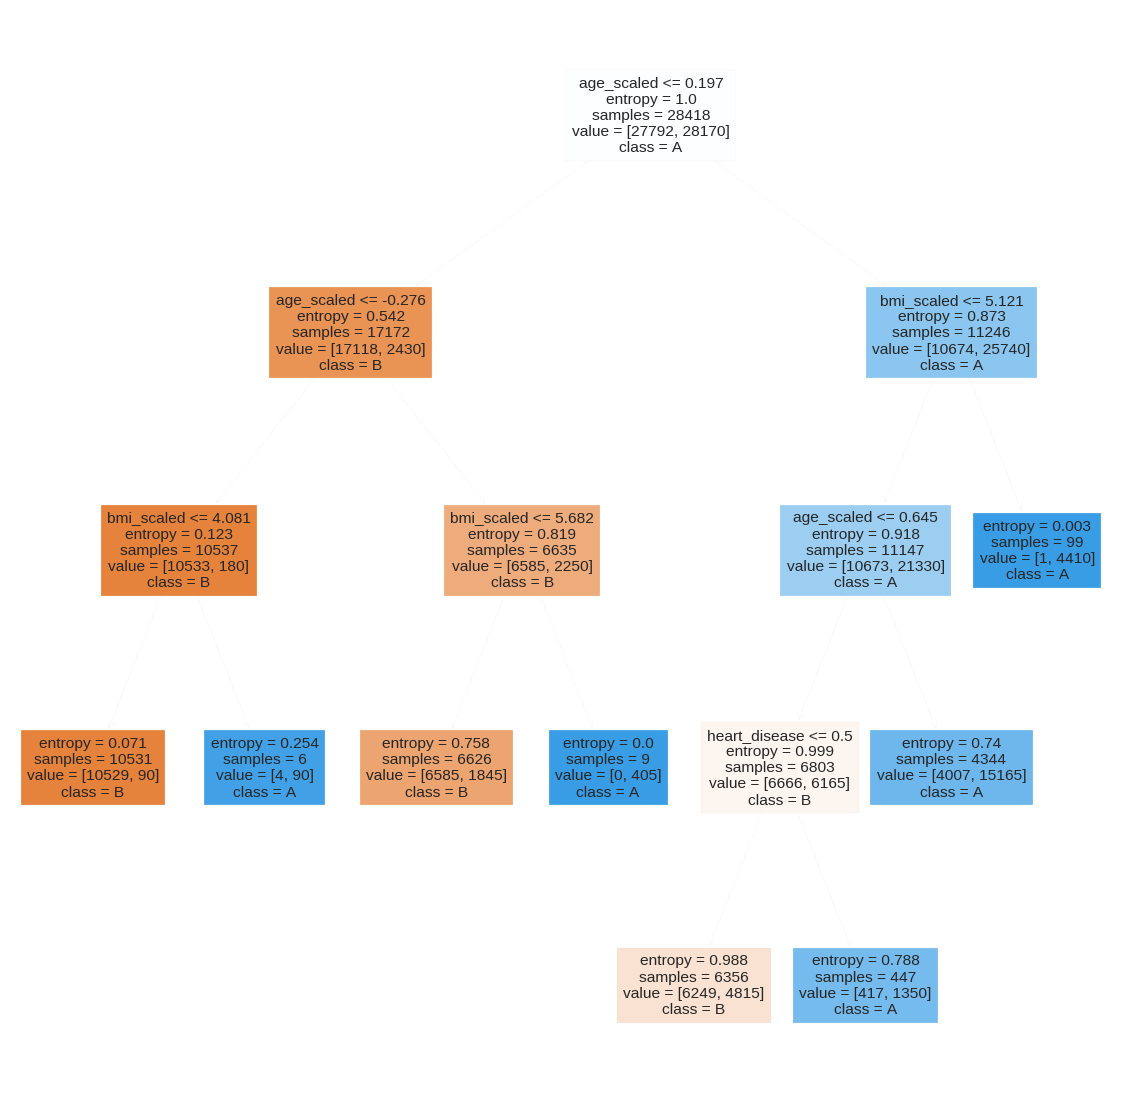

In [26]:
plt.figure(figsize=(20,20))
tree.plot_tree(cart, filled=True, feature_names=X_train.columns, class_names=['B', 'A']);

In [78]:
# 3.1 logistic regression

In [273]:
#find the best hyperparameters

hyperparameters_logreg = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                   'multi_class': ['auto', 'ovr', 'multinomial'], 
                   'verbose': [0,1]}

gscv_logreg = GridSearchCV(LogisticRegression(),
                    param_grid=hyperparameters_logreg,
                    scoring='roc_auc',
                    cv=5, 
                    n_jobs=-1)
gscv_logreg_results = gscv_logreg.fit(X_train, y_train)
gscv_logreg_results.best_params_

/home/liavonava/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs', 'verbose': 0}

In [ ]:
# logreg = LogisticRegression(multi_class='auto', 
#                             penalty='l1', 
#                             solver='liblinear', 
#                             verbose=0,
#                             max_iter=1000,
#                             class_weight={0:1, 1:54})

In [275]:

logreg = LogisticRegression(multi_class='auto', 
                            penalty='l2', 
                            solver='lbfgs', 
                            verbose=0,
                            max_iter=1000,
                            class_weight={0:1, 1:45})
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 45}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [276]:
y_pred_logreg = logreg.predict(X_test)

In [277]:
print(classification_report(y_test, y_pred_logreg));

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      6948
           1       0.07      0.78      0.13       157

    accuracy                           0.78      7105
   macro avg       0.53      0.78      0.50      7105
weighted avg       0.97      0.78      0.86      7105



In [278]:
CM_logreg = confusion_matrix(y_test, y_pred_logreg)
CM_logreg

array([[5394, 1554],
       [  34,  123]])

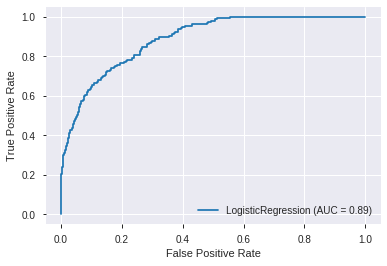

In [279]:
plot_roc_curve(logreg, X_test, y_test);

In [280]:
AUC_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
print(f'AUC score for logistic regression model is {AUC_logreg: .5f}')

AUC score for logistic regression model is  0.88654


In [281]:
f1_score_logreg = f1_score(y_test, y_pred_logreg, average='weighted')
print(f'weighted F1 score for logistic regression model is {f1_score_logreg: .5f}')
# Calculate metrics for each label, and find their average weighted by support 
# (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.

weighted F1 score for logistic regression model is  0.85539


In [282]:
print('True positive is predicted with probability 78.3%, False Negative with 77.6%')

True positive is predicted with probability 78.3%, False Negative with 77.6%


In [ ]:
###############################################################################################

In [ ]:
# 3.2 Random Forest

In [283]:
depth = list(range(1,10))

hyperparameters_rf = {'n_estimators':list(range(10,110, 10)), 
                   'criterion':['gini', 'entropy'], 
                   'max_samples':[0.2 ,0.5, 0.8], 
                   'max_depth': depth}

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       param_grid=hyperparameters_rf,
                       scoring='roc_auc',
                       cv=5, 
                       n_jobs=-1)

gscv_rf_results = gscv_rf.fit(X_train, y_train)
gscv_rf_results.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_samples': 0.8,
 'n_estimators': 90}

In [ ]:
# rf = RandomForestClassifier(criterion='gini', 
#                                   max_samples=0.2, 
#                                   max_depth=7, 
#                                   n_estimators=10, 
#                                   n_jobs=-1, 
#                                   class_weight={0:1, 1:54})

In [284]:
rf = RandomForestClassifier(criterion='entropy', 
                                  max_samples=0.8, 
                                  max_depth=5, 
                                  n_estimators=90, 
                                  n_jobs=-1, 
                                  class_weight={0:1, 1:45})
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 45}, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=0.8, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=90, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [285]:
y_pred_rf = rf.predict(X_test)

In [286]:
print(classification_report(y_test, y_pred_rf));

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      6948
           1       0.07      0.85      0.12       157

    accuracy                           0.73      7105
   macro avg       0.53      0.79      0.48      7105
weighted avg       0.97      0.73      0.83      7105



In [287]:
CM_rf = confusion_matrix(y_test, y_pred_rf)
CM_rf

array([[5083, 1865],
       [  24,  133]])

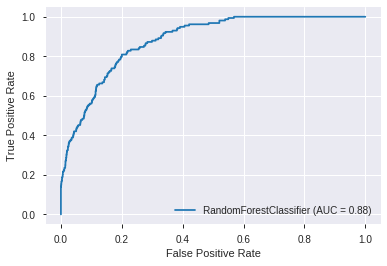

In [288]:
plot_roc_curve(rf, X_test, y_test);

In [289]:
AUC_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print(f'AUC score for logistic regression model is {AUC_rf: .5f}')

AUC score for logistic regression model is  0.88097


In [291]:
f1_score_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f'weighted F1 score for logistic regression model is {f1_score_rf: .5f}')

weighted F1 score for logistic regression model is  0.82739


In [505]:
print('True positive is predicted with probability 60.5%, False Negative with 83,3%')

True positive is predicted with probability 60.5%, False Negative with 83,3%


In [ ]:
# 3.3 SVM 

In [292]:
hyperparameters_svm = {'kernel':['rbf', 'linear', 'poly', 'sigmoid'], 
                   'gamma':['scale', 'auto']}

gscv_svm = GridSearchCV(SVC(),
                    param_grid=hyperparameters_svm,
                    scoring='roc_auc',
                    n_jobs=-1)

gscv_results_svm = gscv_svm.fit(X_train,y_train)
gscv_results_svm.best_params_

/home/liavonava/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



{'gamma': 'scale', 'kernel': 'linear'}

In [303]:
svm = SVC(C=1, kernel='linear', gamma='scale', class_weight={0:1, 1:45}, probability=True)

In [304]:
svm.fit(X_train, y_train)

SVC(C=3, break_ties=False, cache_size=200, class_weight={0: 1, 1: 45},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [305]:
y_pred_svm=svm.predict(X_test)

In [306]:
print(classification_report(y_test, y_pred_svm));

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      6948
           1       0.07      0.80      0.13       157

    accuracy                           0.77      7105
   macro avg       0.53      0.78      0.50      7105
weighted avg       0.97      0.77      0.85      7105



In [307]:
CM_svm = confusion_matrix(y_test, y_pred_svm)
CM_svm

array([[5321, 1627],
       [  32,  125]])

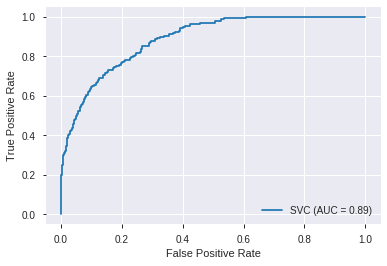

In [308]:
plot_roc_curve(svm, X_test, y_test);

In [309]:
AUC_svm = roc_auc_score(y_test, svm.predict_proba(X_test)[:,1])
print(f'AUC score for SVM model is {AUC_svm: .5f}')

AUC score for SVM model is  0.88603


In [310]:
f1_score_svm = f1_score(y_test, y_pred_svm, average='weighted')
print(f'weighted F1 score for logistic regression model is {f1_score_svm: .5f}')

weighted F1 score for logistic regression model is  0.84891


In [505]:
print('True positive is predicted with probability %, False Negative with %')

True positive is predicted with probability 60.5%, False Negative with 83,3%


In [ ]:
#################################################################################################################

In [50]:
# 3.4 xgboost

In [112]:
hyperparameters_xgb = {'n_estimators':[200,250,300,350,400,450,500],
                       'max_depth': [1,2,3,4,5], 
                       'verbosity': [0,1]}

gscv_xgb = GridSearchCV(XGBClassifier(),
                    param_grid=hyperparameters_xgb,
                    scoring='roc_auc', 
                    cv=3,
                    n_jobs=-1)

gscv_xgb_results = gscv_xgb.fit(X_train, y_train)
gscv_xgb_results.best_params_

{'max_depth': 1, 'n_estimators': 200, 'verbosity': 0}

In [128]:
xgb = XGBClassifier(n_estimators=200, max_depth=1, verbosity=0,max_delta_step=1, scale_pos_weight=44.367816092)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=44.367816092,
              seed=None, silent=None, subsample=1, verbosity=0)

In [114]:
y_pred_xgb = xgb.predict(X_test)

In [115]:
yy = xgb.predict(X_train[:1])

In [116]:
confusion_matrix(y_test, y_pred_xgb)

array([[5506, 1442],
       [  34,  123]])

In [117]:
print(classification_report(y_test, y_pred_xgb));

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      6948
           1       0.08      0.78      0.14       157

    accuracy                           0.79      7105
   macro avg       0.54      0.79      0.51      7105
weighted avg       0.97      0.79      0.87      7105



In [118]:
xgb.score(X_test, y_test)

0.792258972554539

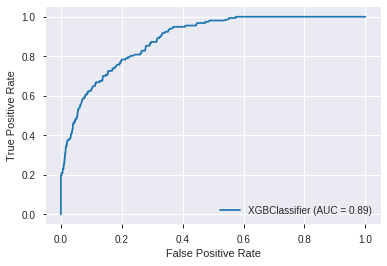

In [119]:
plot_roc_curve(xgb, X_test, y_test);

In [120]:
AUC_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
print(f'AUC score for xgb model is {AUC_xgb: .5f}')

AUC score for xgb model is  0.88668


In [121]:
f1_score_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
print(f'weighted F1 score for xgb model is {f1_score_xgb: .5f}')

weighted F1 score for xgb model is  0.86548


In [122]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred_xgb, average='weighted')

(0.9736380213778949, 0.792258972554539, 0.8654778848074166, None)

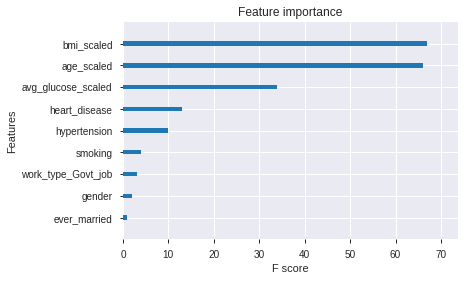

In [123]:
#from xgboost import plot_importance
xgboost.plot_importance(xgb, show_values=False);

In [124]:
! pip install graphviz

In [486]:
! pip install dot

  ERROR: Could not find a version that satisfies the requirement dot (from versions: none)
ERROR: No matching distribution found for dot


In [484]:
import os
os.environ["PATH"] += os.pathsep +  "/home/liavonava/anaconda3/lib/python3.7/site-packages/graphiz/"

In [ ]:
xgboost.plot_tree(xgb, num_trees=199);

In [ ]:
plt.savefig('tree.png')

In [505]:
#print('True positive is predicted with probability %, False Negative with %')

True positive is predicted with probability 60.5%, False Negative with 83,3%


In [ ]:
#################################################################################################################

In [ ]:
# 3.5 catboost

In [388]:
hyperparameters_cat = {'learning_rate': [0.05, 0.1, 1],
                        'depth': list(range(1,10)),
                        'l2_leaf_reg': [1, 3, 5, 7, 9]}

gscv_cat = GridSearchCV(CatBoostClassifier(),
                    param_grid=hyperparameters_cat,
                    scoring='roc_auc',
                    n_jobs=-1)

gscv_cat_results = gscv_cat.fit(X_train, y_train)
gscv_cat_results.best_params_

/home/liavonava/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



0:	learn: 0.6068747	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.5306350	total: 76.5ms	remaining: 38.2s
2:	learn: 0.4636217	total: 91ms	remaining: 30.3s
3:	learn: 0.4113450	total: 102ms	remaining: 25.5s
4:	learn: 0.3657421	total: 113ms	remaining: 22.5s
5:	learn: 0.3252405	total: 125ms	remaining: 20.8s
6:	learn: 0.2910871	total: 138ms	remaining: 19.6s
7:	learn: 0.2622681	total: 150ms	remaining: 18.6s
8:	learn: 0.2379220	total: 161ms	remaining: 17.8s
9:	learn: 0.2173219	total: 173ms	remaining: 17.1s
10:	learn: 0.1998586	total: 184ms	remaining: 16.5s
11:	learn: 0.1850236	total: 194ms	remaining: 16s
12:	learn: 0.1723928	total: 202ms	remaining: 15.3s
13:	learn: 0.1616138	total: 209ms	remaining: 14.7s
14:	learn: 0.1525010	total: 217ms	remaining: 14.2s
15:	learn: 0.1445435	total: 223ms	remaining: 13.7s
16:	learn: 0.1377028	total: 231ms	remaining: 13.4s
17:	learn: 0.1299156	total: 238ms	remaining: 13s
18:	learn: 0.1241174	total: 248ms	remaining: 12.8s
19:	learn: 0.1198462	total: 262ms	remaining:

169:	learn: 0.0745051	total: 1.7s	remaining: 8.3s
170:	learn: 0.0745006	total: 1.71s	remaining: 8.28s
171:	learn: 0.0744970	total: 1.71s	remaining: 8.25s
172:	learn: 0.0744931	total: 1.72s	remaining: 8.23s
173:	learn: 0.0744910	total: 1.73s	remaining: 8.2s
174:	learn: 0.0744880	total: 1.73s	remaining: 8.18s
175:	learn: 0.0744821	total: 1.74s	remaining: 8.15s
176:	learn: 0.0744786	total: 1.75s	remaining: 8.13s
177:	learn: 0.0744754	total: 1.76s	remaining: 8.12s
178:	learn: 0.0744068	total: 1.76s	remaining: 8.09s
179:	learn: 0.0744018	total: 1.77s	remaining: 8.07s
180:	learn: 0.0743995	total: 1.78s	remaining: 8.05s
181:	learn: 0.0743962	total: 1.78s	remaining: 8.02s
182:	learn: 0.0743921	total: 1.79s	remaining: 8.01s
183:	learn: 0.0743867	total: 1.8s	remaining: 7.98s
184:	learn: 0.0743210	total: 1.81s	remaining: 8s
185:	learn: 0.0743195	total: 1.83s	remaining: 8s
186:	learn: 0.0743165	total: 1.84s	remaining: 8s
187:	learn: 0.0742648	total: 1.85s	remaining: 8.01s
188:	learn: 0.0742640	tot

345:	learn: 0.0737498	total: 3.14s	remaining: 5.94s
346:	learn: 0.0737494	total: 3.15s	remaining: 5.93s
347:	learn: 0.0737490	total: 3.16s	remaining: 5.92s
348:	learn: 0.0737487	total: 3.17s	remaining: 5.91s
349:	learn: 0.0737475	total: 3.18s	remaining: 5.9s
350:	learn: 0.0737463	total: 3.18s	remaining: 5.89s
351:	learn: 0.0737448	total: 3.19s	remaining: 5.88s
352:	learn: 0.0737444	total: 3.2s	remaining: 5.86s
353:	learn: 0.0737440	total: 3.2s	remaining: 5.85s
354:	learn: 0.0737424	total: 3.21s	remaining: 5.83s
355:	learn: 0.0737410	total: 3.22s	remaining: 5.82s
356:	learn: 0.0737406	total: 3.22s	remaining: 5.8s
357:	learn: 0.0737392	total: 3.23s	remaining: 5.79s
358:	learn: 0.0737378	total: 3.23s	remaining: 5.77s
359:	learn: 0.0737375	total: 3.24s	remaining: 5.76s
360:	learn: 0.0737371	total: 3.25s	remaining: 5.75s
361:	learn: 0.0737356	total: 3.25s	remaining: 5.73s
362:	learn: 0.0737342	total: 3.26s	remaining: 5.72s
363:	learn: 0.0737338	total: 3.27s	remaining: 5.7s
364:	learn: 0.073

510:	learn: 0.0735357	total: 4.37s	remaining: 4.18s
511:	learn: 0.0735349	total: 4.37s	remaining: 4.17s
512:	learn: 0.0735339	total: 4.38s	remaining: 4.16s
513:	learn: 0.0735313	total: 4.39s	remaining: 4.15s
514:	learn: 0.0735304	total: 4.39s	remaining: 4.14s
515:	learn: 0.0735302	total: 4.4s	remaining: 4.13s
516:	learn: 0.0735293	total: 4.41s	remaining: 4.12s
517:	learn: 0.0735285	total: 4.41s	remaining: 4.11s
518:	learn: 0.0735276	total: 4.42s	remaining: 4.1s
519:	learn: 0.0735268	total: 4.44s	remaining: 4.1s
520:	learn: 0.0735265	total: 4.44s	remaining: 4.09s
521:	learn: 0.0735262	total: 4.47s	remaining: 4.09s
522:	learn: 0.0735254	total: 4.48s	remaining: 4.09s
523:	learn: 0.0735251	total: 4.5s	remaining: 4.09s
524:	learn: 0.0735247	total: 4.51s	remaining: 4.08s
525:	learn: 0.0735245	total: 4.53s	remaining: 4.08s
526:	learn: 0.0735235	total: 4.55s	remaining: 4.08s
527:	learn: 0.0735223	total: 4.56s	remaining: 4.08s
528:	learn: 0.0735213	total: 4.57s	remaining: 4.07s
529:	learn: 0.07

689:	learn: 0.0733822	total: 5.79s	remaining: 2.6s
690:	learn: 0.0733817	total: 5.8s	remaining: 2.59s
691:	learn: 0.0733809	total: 5.8s	remaining: 2.58s
692:	learn: 0.0733799	total: 5.81s	remaining: 2.57s
693:	learn: 0.0733791	total: 5.82s	remaining: 2.56s
694:	learn: 0.0733782	total: 5.82s	remaining: 2.56s
695:	learn: 0.0733773	total: 5.83s	remaining: 2.54s
696:	learn: 0.0733764	total: 5.83s	remaining: 2.54s
697:	learn: 0.0733757	total: 5.84s	remaining: 2.53s
698:	learn: 0.0733755	total: 5.85s	remaining: 2.52s
699:	learn: 0.0733747	total: 5.86s	remaining: 2.51s
700:	learn: 0.0733738	total: 5.86s	remaining: 2.5s
701:	learn: 0.0733736	total: 5.87s	remaining: 2.49s
702:	learn: 0.0733730	total: 5.88s	remaining: 2.48s
703:	learn: 0.0733727	total: 5.88s	remaining: 2.47s
704:	learn: 0.0733718	total: 5.89s	remaining: 2.46s
705:	learn: 0.0733715	total: 5.9s	remaining: 2.46s
706:	learn: 0.0733713	total: 5.91s	remaining: 2.45s
707:	learn: 0.0733707	total: 5.91s	remaining: 2.44s
708:	learn: 0.073

874:	learn: 0.0732509	total: 7.24s	remaining: 1.03s
875:	learn: 0.0732507	total: 7.25s	remaining: 1.03s
876:	learn: 0.0732500	total: 7.26s	remaining: 1.02s
877:	learn: 0.0732498	total: 7.27s	remaining: 1.01s
878:	learn: 0.0732491	total: 7.27s	remaining: 1s
879:	learn: 0.0732490	total: 7.28s	remaining: 993ms
880:	learn: 0.0732488	total: 7.29s	remaining: 984ms
881:	learn: 0.0732483	total: 7.29s	remaining: 976ms
882:	learn: 0.0732481	total: 7.3s	remaining: 967ms
883:	learn: 0.0732480	total: 7.31s	remaining: 959ms
884:	learn: 0.0732478	total: 7.31s	remaining: 950ms
885:	learn: 0.0732476	total: 7.32s	remaining: 942ms
886:	learn: 0.0732469	total: 7.33s	remaining: 933ms
887:	learn: 0.0732464	total: 7.33s	remaining: 925ms
888:	learn: 0.0732459	total: 7.34s	remaining: 916ms
889:	learn: 0.0732453	total: 7.34s	remaining: 908ms
890:	learn: 0.0732452	total: 7.35s	remaining: 899ms
891:	learn: 0.0732444	total: 7.36s	remaining: 891ms
892:	learn: 0.0732443	total: 7.36s	remaining: 882ms
893:	learn: 0.07

{'depth': 1, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [389]:
cat=CatBoostClassifier(learning_rate=0.05, depth=1, l2_leaf_reg=3, class_weights=[1, 54])
cat.fit(X_train, y_train)

0:	learn: 0.6752789	total: 19.7ms	remaining: 19.7s
1:	learn: 0.6585183	total: 30.3ms	remaining: 15.1s
2:	learn: 0.6432125	total: 40.8ms	remaining: 13.6s
3:	learn: 0.6305690	total: 51.8ms	remaining: 12.9s
4:	learn: 0.6188111	total: 61.4ms	remaining: 12.2s
5:	learn: 0.6086719	total: 80ms	remaining: 13.2s
6:	learn: 0.5992826	total: 88.6ms	remaining: 12.6s
7:	learn: 0.5887857	total: 96.9ms	remaining: 12s
8:	learn: 0.5805093	total: 104ms	remaining: 11.4s
9:	learn: 0.5722988	total: 111ms	remaining: 10.9s
10:	learn: 0.5656608	total: 117ms	remaining: 10.5s
11:	learn: 0.5587438	total: 124ms	remaining: 10.2s
12:	learn: 0.5530104	total: 130ms	remaining: 9.89s
13:	learn: 0.5471966	total: 137ms	remaining: 9.66s
14:	learn: 0.5426295	total: 143ms	remaining: 9.41s
15:	learn: 0.5385349	total: 150ms	remaining: 9.19s
16:	learn: 0.5277540	total: 158ms	remaining: 9.11s
17:	learn: 0.5205820	total: 164ms	remaining: 8.94s
18:	learn: 0.5190041	total: 171ms	remaining: 8.81s
19:	learn: 0.5167178	total: 177ms	rem

160:	learn: 0.4174430	total: 1.7s	remaining: 8.86s
161:	learn: 0.4174142	total: 1.72s	remaining: 8.88s
162:	learn: 0.4173874	total: 1.73s	remaining: 8.87s
163:	learn: 0.4172970	total: 1.74s	remaining: 8.86s
164:	learn: 0.4172648	total: 1.75s	remaining: 8.84s
165:	learn: 0.4172023	total: 1.75s	remaining: 8.81s
166:	learn: 0.4171406	total: 1.76s	remaining: 8.78s
167:	learn: 0.4170430	total: 1.76s	remaining: 8.74s
168:	learn: 0.4169890	total: 1.77s	remaining: 8.71s
169:	learn: 0.4165807	total: 1.78s	remaining: 8.69s
170:	learn: 0.4165389	total: 1.79s	remaining: 8.66s
171:	learn: 0.4156663	total: 1.79s	remaining: 8.63s
172:	learn: 0.4154750	total: 1.8s	remaining: 8.61s
173:	learn: 0.4154264	total: 1.81s	remaining: 8.57s
174:	learn: 0.4153705	total: 1.81s	remaining: 8.54s
175:	learn: 0.4153324	total: 1.82s	remaining: 8.51s
176:	learn: 0.4152882	total: 1.82s	remaining: 8.48s
177:	learn: 0.4152729	total: 1.83s	remaining: 8.45s
178:	learn: 0.4152472	total: 1.84s	remaining: 8.42s
179:	learn: 0.

328:	learn: 0.4073373	total: 3.15s	remaining: 6.42s
329:	learn: 0.4073188	total: 3.16s	remaining: 6.41s
330:	learn: 0.4073007	total: 3.16s	remaining: 6.39s
331:	learn: 0.4072830	total: 3.17s	remaining: 6.39s
332:	learn: 0.4071966	total: 3.19s	remaining: 6.38s
333:	learn: 0.4071794	total: 3.2s	remaining: 6.38s
334:	learn: 0.4071614	total: 3.21s	remaining: 6.37s
335:	learn: 0.4071451	total: 3.22s	remaining: 6.36s
336:	learn: 0.4071269	total: 3.23s	remaining: 6.35s
337:	learn: 0.4071096	total: 3.24s	remaining: 6.34s
338:	learn: 0.4070892	total: 3.24s	remaining: 6.33s
339:	learn: 0.4070752	total: 3.25s	remaining: 6.32s
340:	learn: 0.4070584	total: 3.27s	remaining: 6.31s
341:	learn: 0.4070418	total: 3.27s	remaining: 6.29s
342:	learn: 0.4070253	total: 3.28s	remaining: 6.28s
343:	learn: 0.4070086	total: 3.29s	remaining: 6.27s
344:	learn: 0.4069920	total: 3.29s	remaining: 6.25s
345:	learn: 0.4069756	total: 3.3s	remaining: 6.24s
346:	learn: 0.4069585	total: 3.31s	remaining: 6.24s
347:	learn: 0.

493:	learn: 0.4036933	total: 4.82s	remaining: 4.93s
494:	learn: 0.4036731	total: 4.83s	remaining: 4.93s
495:	learn: 0.4036625	total: 4.85s	remaining: 4.93s
496:	learn: 0.4036520	total: 4.88s	remaining: 4.94s
497:	learn: 0.4036417	total: 4.91s	remaining: 4.95s
498:	learn: 0.4036316	total: 4.94s	remaining: 4.96s
499:	learn: 0.4036066	total: 4.96s	remaining: 4.96s
500:	learn: 0.4035779	total: 4.99s	remaining: 4.97s
501:	learn: 0.4035676	total: 5s	remaining: 4.96s
502:	learn: 0.4035564	total: 5.02s	remaining: 4.96s
503:	learn: 0.4035451	total: 5.03s	remaining: 4.95s
504:	learn: 0.4034951	total: 5.06s	remaining: 4.96s
505:	learn: 0.4034742	total: 5.09s	remaining: 4.97s
506:	learn: 0.4034643	total: 5.11s	remaining: 4.96s
507:	learn: 0.4034541	total: 5.12s	remaining: 4.96s
508:	learn: 0.4034442	total: 5.13s	remaining: 4.95s
509:	learn: 0.4034200	total: 5.16s	remaining: 4.96s
510:	learn: 0.4034103	total: 5.19s	remaining: 4.97s
511:	learn: 0.4034007	total: 5.21s	remaining: 4.97s
512:	learn: 0.4

664:	learn: 0.4014715	total: 6.88s	remaining: 3.46s
665:	learn: 0.4014641	total: 6.88s	remaining: 3.45s
666:	learn: 0.4014563	total: 6.89s	remaining: 3.44s
667:	learn: 0.4014420	total: 6.9s	remaining: 3.43s
668:	learn: 0.4014342	total: 6.91s	remaining: 3.42s
669:	learn: 0.4013966	total: 6.93s	remaining: 3.41s
670:	learn: 0.4013888	total: 6.93s	remaining: 3.4s
671:	learn: 0.4013821	total: 6.94s	remaining: 3.39s
672:	learn: 0.4013748	total: 6.95s	remaining: 3.38s
673:	learn: 0.4013674	total: 6.96s	remaining: 3.37s
674:	learn: 0.4013529	total: 6.97s	remaining: 3.35s
675:	learn: 0.4013457	total: 6.97s	remaining: 3.34s
676:	learn: 0.4013384	total: 6.98s	remaining: 3.33s
677:	learn: 0.4013267	total: 6.98s	remaining: 3.32s
678:	learn: 0.4013195	total: 6.99s	remaining: 3.3s
679:	learn: 0.4013118	total: 7s	remaining: 3.29s
680:	learn: 0.4013045	total: 7s	remaining: 3.28s
681:	learn: 0.4012977	total: 7.01s	remaining: 3.27s
682:	learn: 0.4012901	total: 7.02s	remaining: 3.26s
683:	learn: 0.4012830

842:	learn: 0.3998560	total: 8.1s	remaining: 1.51s
843:	learn: 0.3998441	total: 8.11s	remaining: 1.5s
844:	learn: 0.3998282	total: 8.12s	remaining: 1.49s
845:	learn: 0.3998220	total: 8.13s	remaining: 1.48s
846:	learn: 0.3998164	total: 8.13s	remaining: 1.47s
847:	learn: 0.3998042	total: 8.14s	remaining: 1.46s
848:	learn: 0.3997982	total: 8.15s	remaining: 1.45s
849:	learn: 0.3997931	total: 8.15s	remaining: 1.44s
850:	learn: 0.3997876	total: 8.16s	remaining: 1.43s
851:	learn: 0.3997822	total: 8.17s	remaining: 1.42s
852:	learn: 0.3997769	total: 8.17s	remaining: 1.41s
853:	learn: 0.3997710	total: 8.18s	remaining: 1.4s
854:	learn: 0.3997652	total: 8.19s	remaining: 1.39s
855:	learn: 0.3997580	total: 8.19s	remaining: 1.38s
856:	learn: 0.3997516	total: 8.2s	remaining: 1.37s
857:	learn: 0.3997424	total: 8.2s	remaining: 1.36s
858:	learn: 0.3997366	total: 8.21s	remaining: 1.35s
859:	learn: 0.3997308	total: 8.21s	remaining: 1.34s
860:	learn: 0.3997250	total: 8.22s	remaining: 1.33s
861:	learn: 0.399

In [390]:
y_pred_cat = cat.predict(X_test)

In [391]:
confusion_matrix(y_test, y_pred_cat)

array([[5192, 1756],
       [  30,  127]])

In [392]:
print(classification_report(y_test, y_pred_cat));

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      6948
           1       0.07      0.81      0.12       157

    accuracy                           0.75      7105
   macro avg       0.53      0.78      0.49      7105
weighted avg       0.97      0.75      0.84      7105



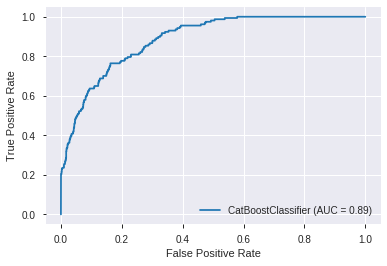

In [393]:
plot_roc_curve(cat, X_test, y_test);

In [394]:
AUC_cat = roc_auc_score(y_test, cat.predict_proba(X_test)[:,1])
print(f'AUC score for SVM model is {AUC_cat: .5f}')

AUC score for SVM model is  0.88606


In [395]:
f1_score_cat = f1_score(y_test, y_pred_cat, average='weighted')
print(f'weighted F1 score for logistic regression model is {f1_score_cat: .5f}')

weighted F1 score for logistic regression model is  0.83714


In [505]:
#print('True positive is predicted with probability %, False Negative with %')

True positive is predicted with probability 60.5%, False Negative with 83,3%


In [ ]:
####################################

In [ ]:
# 3.6 NN

In [408]:
nn = Sequential()
nn.add(Dense(64, input_dim=15, activation='relu', kernel_initializer='he_uniform'))
nn.add(BatchNormalization())
nn.add(Dropout(0.5))
#nn.add(Dense(64, activation='relu'))
#nn.add(Dropout(0.5))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer='adam')

In [409]:
nn.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, class_weight={0:1, 1:45})

In [410]:
y_pred_proba = nn.predict(X_test)
y_pred_nn = [round(y[0]) for y in y_pred_proba]

In [412]:
confusion_matrix(y_test, y_pred_nn)

array([[5386, 1562],
       [  29,  128]])

In [413]:
print(classification_report(y_test, y_pred_nn));

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      6948
           1       0.08      0.82      0.14       157

    accuracy                           0.78      7105
   macro avg       0.54      0.80      0.50      7105
weighted avg       0.97      0.78      0.86      7105



In [ ]:
# !!!!!!! ROC AUC CURVE

In [414]:
AUC_nn = roc_auc_score(y_test, y_pred_proba)
print(f'AUC score for SVM model is {AUC_nn: .5f}')

AUC score for SVM model is  0.88024


In [415]:
f1_score_nn = f1_score(y_test, y_pred_nn, average='weighted')
print(f'weighted F1 score for logistic regression model is {f1_score_nn: .5f}')

weighted F1 score for logistic regression model is  0.85512


In [416]:
#print('True positive is predicted with probability %, False Negative with %')

In [421]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_proba)

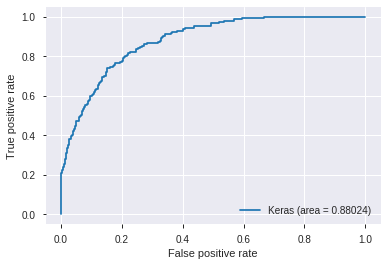

In [424]:
plt.figure()
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.5f})'.format(AUC_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()